In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.lines import Line2D

import torch

import pickle
import os

In [89]:
from lib.dataset_config_parser.trained_model_config_parser import parse_prefit_glm_paths
from optimization_encoder.trial_glm import load_fitted_glm_families
from denoise_inverse_alg.glm_inverse_alg import PackedGLMTensors, reinflate_cropped_glm_model, \
    noreduce_bernoulli_neg_LL
import lib.data_utils.dynamic_data_util as ddu

In [14]:
BASEPATH='/Volumes/Backup/Scratch/Users/wueric/SUBMISSION_DATA_reconstruction/flashed/' # change this

HEIGHT = 160
WIDTH = 256

SAMPLES_PER_BIN = 20 # 1 ms bins @ 20 kHz sampling rate

In [3]:
device = torch.device('cuda:0') # change this for your machine

# Demonstration for flashed image reconstruction

### Load the demonstration dataset

In [7]:
with open(os.path.join(BASEPATH, '2018_08_07_5_flashed_demo_data.p'), 'rb') as pfile:
    demo_dataset = pickle.load(pfile)

In [8]:
demo_data_dict = demo_dataset['data']
demo_data_metadata = demo_dataset['metadata']

In [16]:
response_vector = demo_data_dict['spikes']
stimulus_images = demo_data_dict['stimulus']
time_component = demo_data_dict['time_component']

### Load the models

In [9]:
# metadata keeping track of what cell is what
CELL_ORDERING_PATH = os.path.join(BASEPATH, 'pickles', 'reclassed.p')

################################################################
# Load the cell types and matching
with open(CELL_ORDERING_PATH, 'rb') as ordered_cells_file:
    cells_ordered = pickle.load(ordered_cells_file)  # type: OrderedMatchedCellsStruct
ct_order = cells_ordered.get_cell_types()

cell_ids_as_ordered_list = []
for ct in ct_order:
    cell_ids_as_ordered_list.extend(cells_ordered.get_reference_cell_order(ct))

In [46]:
on_parasol_list = cells_ordered.get_reference_cell_order('ON parasol')
off_parasol_list = cells_ordered.get_reference_cell_order('OFF parasol')
on_midget_list = cells_ordered.get_reference_cell_order('ON midget')
off_midget_list = cells_ordered.get_reference_cell_order('OFF midget')

In [11]:
# metadata for keeping track of the spatial filter bounding box for each cell
with open(os.path.join(BASEPATH, 'pickles', 'bigger_crop_bbox_with_midgets.pickle'), 'rb') as pfile:
    bounding_boxes_by_type = pickle.load(pfile)

In [12]:
# load the pre-fitted LNBRC models from disk
fitted_glm_paths = parse_prefit_glm_paths(os.path.join(BASEPATH, 'models', 'nojitter.yaml'))
fitted_glm_families = load_fitted_glm_families(fitted_glm_paths)

In [15]:
# pack the fitted models into tensors
packed_glm_tensors = reinflate_cropped_glm_model(
    fitted_glm_families,
    bounding_boxes_by_type,
    cells_ordered,
    HEIGHT,
    WIDTH,
    downsample_factor=demo_data_metadata['downsample_factor'],
    crop_width_low=demo_data_metadata['crop_width_low'],
    crop_width_high=demo_data_metadata['crop_width_high'],
    crop_height_low=demo_data_metadata['crop_height_low'],
    crop_height_high=demo_data_metadata['crop_height_high']
)

### Look at example model parameters

In [31]:
EXAMPLE_ID = 10
EXAMPLE_PARAMS = fitted_glm_families['ON parasol'].fitted_models[EXAMPLE_ID]
EXAMPLE_BOUNDING_BOX = bounding_boxes_by_type['ON parasol'][cells_ordered.get_idx_for_same_type_cell_id_list('ON parasol', [EXAMPLE_ID, ])[0]]

In [32]:
timecourse_basis = fitted_glm_families['ON parasol'].timecourse_basis
feedback_basis = fitted_glm_families['ON parasol'].feedback_basis
coupling_basis = fitted_glm_families['ON parasol'].coupling_basis

In [33]:
full_spatial_filter = np.zeros((HEIGHT, WIDTH), dtype=np.float32)

putback_slice_obj_h, putback_slice_obj_w = EXAMPLE_BOUNDING_BOX.make_precropped_sliceobj(
    downsample_factor=demo_data_metadata['downsample_factor'],
    crop_wlow=demo_data_metadata['crop_width_low'],
    crop_whigh=demo_data_metadata['crop_width_high'],
    crop_hlow=demo_data_metadata['crop_height_low'],
    crop_hhigh=demo_data_metadata['crop_height_high'])

full_spatial_filter[putback_slice_obj_h, putback_slice_obj_w] = EXAMPLE_PARAMS.spatial_weights

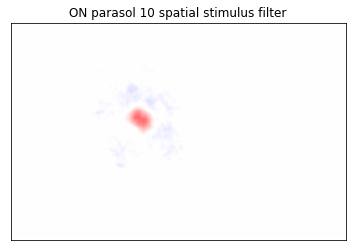

In [34]:
LIM=2e-2
fig, ax = plt.subplots()
ax.imshow(full_spatial_filter, cmap='bwr', vmin=-LIM, vmax=LIM)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('equal')
ax.set_title(f'ON parasol {EXAMPLE_ID} spatial stimulus filter')
plt.show()

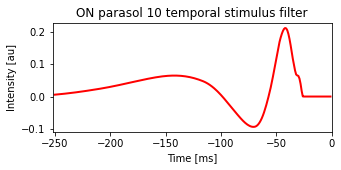

In [35]:
timecourse_filter = (EXAMPLE_PARAMS.timecourse_weights @ timecourse_basis).squeeze(0)
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_xlim([-252, 0])
ax.plot(np.r_[-250:0], timecourse_filter, color='red', lw=2)
ax.set_title(f'ON parasol {EXAMPLE_ID} temporal stimulus filter')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Intensity [au]')
plt.show()

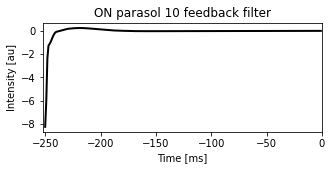

In [36]:
feedback_filter = (EXAMPLE_PARAMS.feedback_weights @ feedback_basis).squeeze(0)
fig, ax = plt.subplots(figsize=(5, 2))
ax.set_xlim([-252, 0])

ax.plot(np.r_[-250:0], feedback_filter[::-1], color='black', lw=2)

ax.set_title(f'ON parasol {EXAMPLE_ID} feedback filter')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Intensity [au]')

plt.show()

In [37]:
coupling_weights, coupling_cells = EXAMPLE_PARAMS.coupling_cells_weights
coupling_filters = coupling_weights @ coupling_basis

COUPLED_CELL_TYPES = cells_ordered.get_cell_types()
coupled_filters_by_type = {ct: [] for ct in COUPLED_CELL_TYPES}

for ix, coupled_cell_id in enumerate(coupling_cells):
    coupled_type = cells_ordered.get_cell_type_for_cell_id(coupled_cell_id)
    coupled_filters_by_type[coupled_type].append(coupling_filters[ix, :])

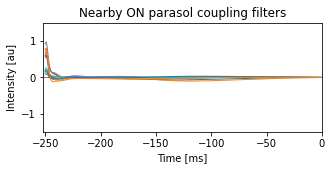

In [39]:
DEMO_COUPLED_TYPE = 'ON parasol'
COUPLE_MAX = 1.5

fig, ax = plt.subplots(figsize=(5, 2))
ax.set_xlim([-252, 0])
ax.axhline(y=0, color='black', lw=0.5, xmin=0, xmax=1)

for cf in coupled_filters_by_type[DEMO_COUPLED_TYPE]:
    ax.plot(np.r_[-250:0], cf[::-1], lw=1)
ax.set_ylim([-COUPLE_MAX, COUPLE_MAX])

ax.set_title(f'Nearby {DEMO_COUPLED_TYPE} coupling filters')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Intensity [au]')

plt.show()

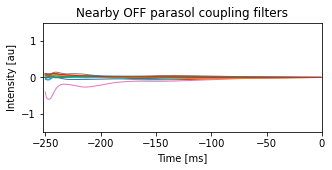

In [40]:
DEMO_COUPLED_TYPE = 'OFF parasol'
COUPLE_MAX = 1.5

fig, ax = plt.subplots(figsize=(5, 2))
ax.set_xlim([-252, 0])
ax.axhline(y=0, color='black', lw=0.5, xmin=0, xmax=1)

for cf in coupled_filters_by_type[DEMO_COUPLED_TYPE]:
    ax.plot(np.r_[-250:0], cf[::-1], lw=1)
ax.set_ylim([-COUPLE_MAX, COUPLE_MAX])

ax.set_title(f'Nearby {DEMO_COUPLED_TYPE} coupling filters')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Intensity [au]')

plt.show()

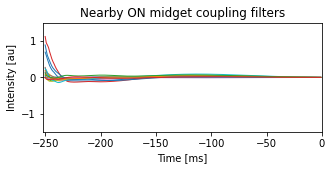

In [41]:
DEMO_COUPLED_TYPE = 'ON midget'
COUPLE_MAX = 1.5

fig, ax = plt.subplots(figsize=(5, 2))
ax.set_xlim([-252, 0])
ax.axhline(y=0, color='black', lw=0.5, xmin=0, xmax=1)

for cf in coupled_filters_by_type[DEMO_COUPLED_TYPE]:
    ax.plot(np.r_[-250:0], cf[::-1], lw=1)
ax.set_ylim([-COUPLE_MAX, COUPLE_MAX])

ax.set_title(f'Nearby {DEMO_COUPLED_TYPE} coupling filters')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Intensity [au]')

plt.show()

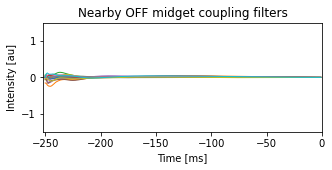

In [42]:
DEMO_COUPLED_TYPE = 'OFF midget'
COUPLE_MAX = 1.5

fig, ax = plt.subplots(figsize=(5, 2))
ax.set_xlim([-252, 0])
ax.axhline(y=0, color='black', lw=0.5, xmin=0, xmax=1)

for cf in coupled_filters_by_type[DEMO_COUPLED_TYPE]:
    ax.plot(np.r_[-250:0], cf[::-1], lw=1)
ax.set_ylim([-COUPLE_MAX, COUPLE_MAX])

ax.set_title(f'Nearby {DEMO_COUPLED_TYPE} coupling filters')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Intensity [au]')

plt.show()

### Look at example rasters

In [85]:
single_response = response_vector[9,::-1, :]

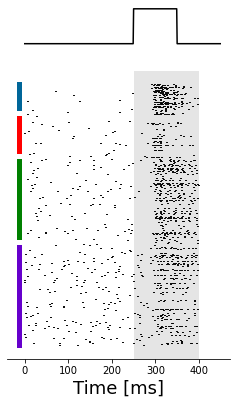

In [86]:
MAX_SAMPLE = 450
outer_gs = gridspec.GridSpec(1, 1, width_ratios=[1])
raster_gs = gridspec.GridSpecFromSubplotSpec(3, 1, height_ratios=[0.6, 0.4, 3], subplot_spec=outer_gs[0])

fig = plt.figure(figsize=(4, 8))

CELL_TYPE_DICT = {
    'ON parasol' : (on_parasol_list, "#006699"),
    'OFF parasol' : (off_parasol_list, "#ff0000"),
    'ON midget' : (on_midget_list, "#008000"),
    'OFF midget' : (off_midget_list, "#6600cc")
}

raster_ax = fig.add_subplot(raster_gs[2])
spike_locations = np.argwhere(single_response[:, :])

event_acc = []
for i in range(single_response.shape[0]):
    event_acc.append(spike_locations[spike_locations[:,0] == i][:, 1])
for i in range(2):
    raster_ax.eventplot(event_acc, color='black')
raster_ax.set_xlim([0, MAX_SAMPLE])

acc = len(cell_ids_as_ordered_list)
for i, (cell_type, val) in enumerate(CELL_TYPE_DICT.items()):
    
    cell_list, color = val
    
    line = Line2D([-12.5, -12.5], [acc - len(cell_list), acc], 
                  color=color, 
                  linewidth=5)
    line.set_clip_on(False)
    raster_ax.add_line(line)
    
    if i != 0:
        line2 = Line2D([-17, -8], [acc+2.5, acc+2.5],
                       color='#ffffff',
                       linewidth=5)
        line2.set_clip_on(False)
        raster_ax.add_line(line2)
    
    acc -= len(cell_list)

raster_ax.spines['top'].set_visible(False)
raster_ax.spines['right'].set_visible(False)
raster_ax.spines['bottom'].set_visible(True)
raster_ax.spines['left'].set_visible(False)
raster_ax.yaxis.set_visible(False)
raster_ax.set_xlabel('Time [ms]', fontsize=18)
#raster_ax.set_ylim([-20, 100])
raster_ax.axvspan(250, 250 + 150, alpha=0.2, color='gray', linewidth=0.0)


waveform_ax = fig.add_subplot(raster_gs[1])
waveform_ax.get_shared_x_axes().join(waveform_ax, raster_ax)
stimulus_time = np.zeros((450, ))
stimulus_time[250:350] = 1.0
waveform_ax.plot(np.r_[0:450], stimulus_time, color='black')
waveform_ax.axis('off')


plt.show()

In [91]:
from reconstruction_fns.flashed_reconstruction_toplevel_fns import batch_parallel_generate_flashed_hqs_reconstructions
from generate_cropped_glm_hqs_reconstructions import make_HQS_X_prob_solver_generator_fn, \
    make_HQS_Z_prob_solver_generator_fn, GridSearchParams

In [93]:
hyperparameters = GridSearchParams(0.1, 10, 0.15, 10)
target_reconstructions = batch_parallel_generate_flashed_hqs_reconstructions(
    response_vector,
    (-1.0, 1.0),
    packed_glm_tensors,
    noreduce_bernoulli_neg_LL,
    time_component,
    hyperparameters,
    make_HQS_X_prob_solver_generator_fn,
    make_HQS_Z_prob_solver_generator_fn,
    8,
    device,
    initialize_noise_level=1e-3,
    valid_region_mask=demo_data_metadata['valid_region']
)


16it [00:33,  2.07s/it]                                                                                                                             


### Plot all of the example images

In [95]:
convex_hull_mask_matrix_bool = demo_data_metadata['valid_region']

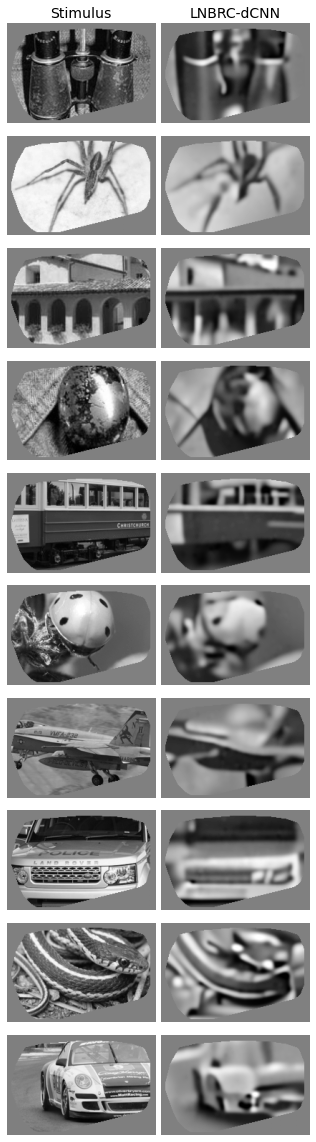

In [99]:
fig, axes = plt.subplots(stimulus_images.shape[0], 2, figsize=(18 / 4, stimulus_images.shape[0] * (8 / 5)))
for ix in range(stimulus_images.shape[0]):
    
    ax = axes[ix][0]
    ax.imshow(stimulus_images[ix, 20:, 16:-32] * convex_hull_mask_matrix_bool[20:, 16:-32], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    
    if ix == 0:
        ax.set_title("Stimulus", fontsize=14)

    ax = axes[ix][1]
    ax.imshow(target_reconstructions[ix, 20:, 16:-32] * convex_hull_mask_matrix_bool[20:, 16:-32], cmap='gray', vmin=-1.0, vmax=1.0)
    ax.axis('off')
    
    if ix == 0:
        ax.set_title("LNBRC-dCNN", fontsize=14)
    
plt.tight_layout()


plt.show()
